# Problem Set 1
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 29-Aug-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the correesponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Simon Stefanus Jacobsson**
- Personnummer: **970417-0456**
  <br/>
  (civic registration number)

## Problem 1
### (2 basic points)

#### Installations
Perform the installations and preparations that are described in the Getting Started instructions. At the end you should have:

1. downloaded the current version of the course material from the github repository or from the course web page;
2. a running python installation that includes the modules listed in the environment.yml file (e.g. numpy, matplotlib, pandas, emcee, scikit-learn, ...);
3. been able to open and run the Jupyter Notebooks with the first week excercises.
Ask the computer lab supervisors for assistance if needed.

In [290]:
# Import the python modules that are needed for this problem set here
#
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('talk')

from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

## Problem 2
### (3 basic points)

#### Generate data

In [291]:
# Generate noisy data with a quadratic feature
# use the following code:
np.random.seed(42)

# X are picked uniform random [0,2]
X = 2 * np.random.rand(100, 1)
# Linear relation to the predicted value, but with Gaussian noise (mean=0, variance=1)
y = 0.5 * X**2 + X + 2 + 0.2 * np.random.randn(100, 1)

#### (a) Perform a linear regression using the Normal Equation
Create the design matrix for a quadratic polynomial and solve the normal equation using matrix inversion.

In [292]:
m = len(X)
X_d = np.c_[np.ones((m, 1)), X, X**2] #design matrix
theta = np.linalg.solve(X_d.T.dot(X_d), X_d.T.dot(y)) #vector containing the approximated coefficients
print('(Assuming a model y = a0 + a1 x + a2 x²)')
print('[a0 a1 a2] = ' + str(theta.T))

(Assuming a model y = a0 + a1 x + a2 x²)
[a0 a1 a2] = [[2.11228054 0.72777588 0.61621274]]


#### (b) Comparisons: 
Compare the coefficients from the true data generator and the normal equation. Plot the data and the model predictions in the same figure.

Difference between theta & true parameters: [[ 5.61402718 27.22241217 23.2425481 ]] [%]


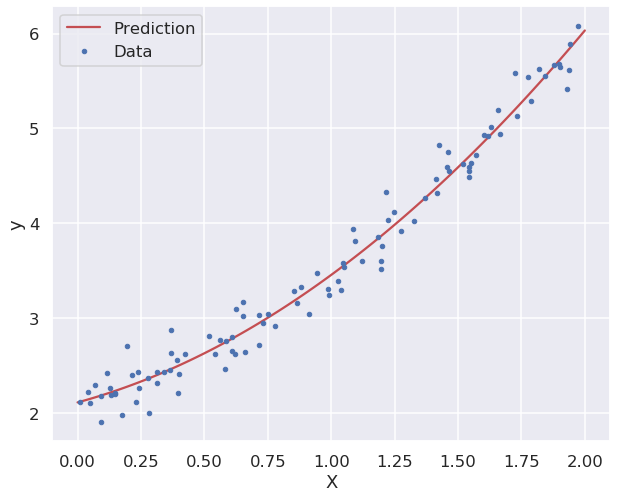

In [293]:
print('Difference between theta & true parameters: ' + str(100*np.abs(theta.T - [2, 1, 0.5])/np.array([2, 1, 0.5])) + ' [%]')

X_predict = np.linspace(0,2,m)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X_predict, np.c_[np.ones((m, 1)), X_predict, X_predict**2].dot(theta), "r-",label="Prediction")
ax.plot(X, y, "b.",label="Data")
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.legend(loc='best');

## Problem 3
### (3 basic points)

There are three files in the directory `DataFiles`:
- `dataset1.dat`
- `dataset2.dat`
- `dataset3.dat`

Each data files contains two columns. The first column corresponds to the independent variables (the array X), and the second column corresponds to the dependent ones (the array y).

#### (a) Perform linear regression with different models
- Load a data set and split it into 60% training and 40% validation data using the python commands below.
- For each data set you should then perform linear regression using polynomial models of order 1,2,3,4,5, and 20.
- Print the fit coefficients for each model and print also the mean-squared error (MSE) for both the training and the validation sets.

Questions to ponder:
- Which order polynomial do you think was used when generating the data?
- Which data set do you think has the most noise?

In [294]:
datafiles = ['DataFiles/dataset1.dat', 'DataFiles/dataset2.dat', 'DataFiles/dataset3.dat']
degrees = [1,2,3,4,5,20]
precision = 3 #choose number of digits to display

for datafile  in datafiles:
    M = max(degrees)

    ### initiate some tables ###
    coeff_table = {'degree ' + str(deg): pd.Series(['' for i in range(0,M+1)], index=['a' + str(i) for i in range(0,M+1)]) for deg in degrees}
    MSE_table = {'degree ' + str(deg): pd.Series(['',''], index=['Training data', 'Validation data']) for deg in degrees}
    
    ### load & split data ###
    X, y = np.loadtxt(datafile, unpack=True)
    m = len(X)
    X = X.reshape(m,1); y = y.reshape(m,1)
    
    # built-in convenience function for splitting data
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.6, random_state=42)

    ### Fit the linear regression model with sklearn ###
    for deg in degrees:
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly = poly_features.fit_transform(X_train)
        # perform the fit
        lin_reg = LinearRegression()
        model = Pipeline([
            ("poly_features", PolynomialFeatures(degree=deg, include_bias=False)),
            ("regul_reg", lin_reg)])
        model.fit(X_train, y_train)

        #calculate MSE
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        MSE_train = mean_squared_error(y_train,y_train_pred)
        MSE_val = mean_squared_error(y_val,y_val_pred)
        
        coeff_table['degree ' + str(deg)][0:deg+1] = np.append(lin_reg.intercept_,lin_reg.coef_).round(precision)
        MSE_table['degree ' + str(deg)]['Training data'] = MSE_train.round(precision)
        MSE_table['degree ' + str(deg)]['Validation data'] = MSE_val.round(precision)
        
    
    ### print coefficients & MSE:s in tables ###
    print('############# Dataset from ' + datafile + ' #############\n')
    print('Table of coefficients:')
    display(pd.DataFrame(coeff_table))
    print('\n')
    print('Table of mean squared errors:')
    display(pd.DataFrame(MSE_table))
    print('\n\n')

print('Discussion:')
print('Data set 1 is probably an order 4 polynomial (5 features) since the \
coefficients & MSE are pretty much unchanged by adding a sixth coefficient. \
\n Data set 2 is probably an order 3 polynomial for the same reasons. \n \
Data set 3 is more probably also degree 3 but it\'s noisier. \n ')


############# Dataset from DataFiles/dataset1.dat #############

Table of coefficients:


,degree 1,degree 2,degree 3,degree 4,degree 5,degree 20
a0,8.644,0.129,0.042,1.994,1.993,1.961
a1,-1.235,-0.637,1.27,0.991,0.982,1.016
a2,,2.587,2.526,0.509,0.51,0.946
a3,,,-0.332,-0.25,-0.245,-0.415
a4,,,,0.25,0.249,-1.416
a5,,,,,-0,0.157
a6,,,,,,2.704
a7,,,,,,-0.025
a8,,,,,,-2.214
a9,,,,,,-0.029




Table of mean squared errors:


,degree 1,degree 2,degree 3,degree 4,degree 5,degree 20
Training data,58.062,4.412,2.326,0.01,0.01,0.008
Validation data,39.879,4.118,2.544,0.006,0.006,0.009





############# Dataset from DataFiles/dataset2.dat #############

Table of coefficients:


,degree 1,degree 2,degree 3,degree 4,degree 5,degree 20
a0,2.925,1.052,0.987,0.968,0.966,0.807
a1,0.397,0.529,1.95,1.953,1.911,2.079
a2,,0.569,0.524,0.543,0.55,2.730
a3,,,-0.247,-0.248,-0.226,-1.075
a4,,,,-0.002,-0.004,-8.332
a5,,,,,-0.002,0.787
a6,,,,,,13.518
a7,,,,,,-0.123
a8,,,,,,-11.071
a9,,,,,,-0.146




Table of mean squared errors:


,degree 1,degree 2,degree 3,degree 4,degree 5,degree 20
Training data,3.999,1.403,0.242,0.242,0.242,0.21
Validation data,3.151,1.278,0.135,0.138,0.14,0.221





############# Dataset from DataFiles/dataset3.dat #############

Table of coefficients:


,degree 1,degree 2,degree 3,degree 4,degree 5,degree 20
a0,3.113,1.01,0.947,0.871,0.864,0.229
a1,0.277,0.424,1.802,1.813,1.646,2.317
a2,,0.639,0.595,0.674,0.698,9.421
a3,,,-0.24,-0.243,-0.155,-3.551
a4,,,,-0.01,-0.014,-33.326
a5,,,,,-0.009,3.147
a6,,,,,,54.073
a7,,,,,,-0.491
a8,,,,,,-44.285
a9,,,,,,-0.584




Table of mean squared errors:


,degree 1,degree 2,degree 3,degree 4,degree 5,degree 20
Training data,8.237,4.966,3.878,3.874,3.868,3.363
Validation data,5.978,3.89,2.16,2.203,2.247,3.543





Discussion:
Data set 1 is probably an order 4 polynomial (5 features) since the coefficients & MSE are pretty much unchanged by adding a sixth coefficient. 
 Data set 2 is probably an order 3 polynomial for the same reasons. 
 Data set 3 is more probably also degree 3 but it's noisier. 
 


## Problem 4
### (2 basic points)

### Standard medical example by applying Bayesian rules of probability

Suppose there is an unknown disease (call it UD) and there is a test for it.

a. The false positive rate is 2.3% ("False positive" means the test says you have UD, but you don't). **Given 100 people who do not have UD, 2.3 of them will test positive.** <br>
b. The false negative rate is 1.4% ("False negative" means you have UD, but the test says you don't). **Given 100 people who do have UD, 1.4 of them will test negative.**

Assume that 1 in 10,000 people have the disease. You are given the test and get a positive result.  Your ultimate goal is to find the probability that you actually have the disease. 
$% Some LaTeX definitions we'll use.
\newcommand{\pr}{\textrm{p}}
$

We'll do it using the Bayesian rules.

We'll use the notation:

* $H$ = "you have UD"
* $\overline H$ = "you do not have UD"  
* $D$ = "you test positive for UD"
* $\overline D$ = "you test negative for UD"  

1. *Before doing a calculation (or thinking too hard :), does your intuition tell you the probability you have the disease is high or low?*
<br>
<br>

2. *In the $p(\cdot | \cdot)$ notation, what is your ultimate goal?*
<br>

<font color='green'>
$p(H | D)$

3. *Express the false positive rate in $p(\cdot | \cdot)$ notation.* \[Ask yourself first: what is to the left of the bar?\]
<br>

<font color='green'>
$p(D | \overline H) = 0.023$

4. *Express the false negative rate in $p(\cdot | \cdot)$ notation. By applying the sum rule, what do you also know? (If you get stuck answering the question, do the next part first.)* 
<br>

<font color='green'>
$p( \overline D | H) = 0.013$

$p( \overline D | H) + p(D | H) = 1$

5. *Should $p(D|H) + p(D|\overline H) = 1$?
    Should $p(D|H) + p(\overline D |H) = 1$?
    (Hint: does the sum rule apply on the left or right of the $|$?)*
<br>

<font color='green'>
$p(D|H) + p(\overline D |H) = 1$ since, if you have UD, the probability of either testing positive or negative is 1.

6. *Apply Bayes' theorem to your result for your ultimate goal (don't put in numbers yet).
   Why is this a useful thing to do here?*
<br>

<font color='green'>
$p(H | D) = \frac{p(D | H) p(H)}{p(D)}$

7. Let's find the other results we need.  *What is $p(H)$?
  What is $p(\overline H)$?*
<br>

<font color='green'>
$p(H) = \frac{1}{10~000}$
    
$p(\overline H) = 1 - p(H)$

8. Finally, we need $p(D)$.  *Apply marginalization first, and then
  the product rule twice to get an expression for $p(D)$ in terms of quantities
  we know.*
<br>

<font color='green'>
$p(D) = p\big((D \cap H) \cup (D \cap \overline H)\big) \stackrel{\text{disjoint sets}}{=} p(D \cap H) + (D \cap \overline H) = p(D | H) p(H) + (D | \overline H) p(\overline H)$


9. *Now plug in numbers into Bayes' theorem and calculate the result.  What do you get?*
<br>


In [295]:
#probability of testing positive given not having UD
p_D_if_nH = 0.023

#probability of testing negative given having UD
p_nD_if_H = 0.013

#probability of testing positive given having UD
#p_D_if_nH + p_D_if_nH = 1
p_D_if_H = 1 - p_nD_if_H

#probability of having/not having UD
p_H = 1/10000
p_nH = 1 - p_H

#probability of testing positive
p_D = p_D_if_H * p_H + p_D_if_nH * p_nH

#probability of having UD given positive test
p_H_if_D = p_D_if_H * p_H / p_D
print(f'p(H|D) = {np.round(p_H_if_D*100,2)} %')


p(H|D) = 0.43 %


## Problem 5 (extra)
### (3 extra points)

#### Reload the third dataset from Problem 3

In [296]:
datafile = 'DataFiles/dataset3.dat'
X, y = np.loadtxt(datafile, unpack=True)
m = len(X)
X = X.reshape(m,1); y = y.reshape(m,1)

#### Validation curves
Create a validation curve for the polynomial model (for different degrees) where you plot the training score and the validation score as a function of the model complexity. 
- The model complexity is simply the degree of the polynomial.
- For the computation of training and validation scores you are encouraged to use cross-validation which is more stable than the use of a single, random pair of training and validation sets.

Question to ponder:
- From this curve: Which order polynomial do you think was used when generating the data?

*Hint:* `scikit-learn` has a function `validation_curve` that might be useful. However, it is certainly instructive to implement the calculation of learning curves yourself.

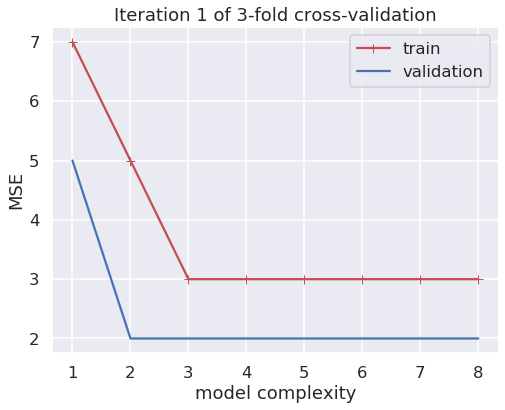

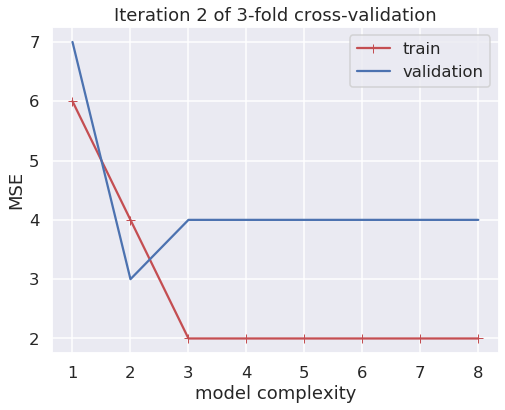

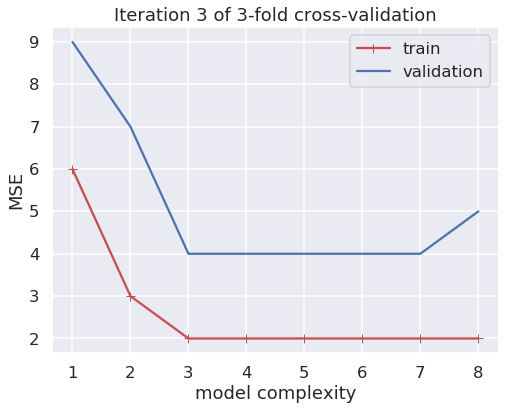

Probably an order 3 polynomial since adding more terms after that point doesn't seem to achieve a better MSE.


In [297]:
nbr_features = 8
degrees = [p for p in range(1,nbr_features+1)]

MSE_train = np.full_like(degrees, np.nan) #initiate
MSE_val = np.full_like(degrees, np.nan) #initiate

### load & split data ###
X, y = np.loadtxt(datafile, unpack=True)
m = len(X)
X = X.reshape(m,1); y = y.reshape(m,1)

# KFold splits data into k disjoint sets for cross-validation
k = 3 #nbr of folds
kf = KFold(n_splits=k, random_state=42)
iteration = 1 #counter

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    ### Fit the linear regression model with sklearn ###
    for i, deg in enumerate(degrees):
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly = poly_features.fit_transform(X_train)
        # perform the fit
        lin_reg = LinearRegression()
        model = Pipeline([
            ("poly_features", PolynomialFeatures(degree=deg, include_bias=False)),
            ("regul_reg", lin_reg)])
        model.fit(X_train, y_train)

        #calculate MSE
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        MSE_train[i] = mean_squared_error(y_train,y_train_pred)
        MSE_val[i] = mean_squared_error(y_val,y_val_pred)
    
    fig,ax = plt.subplots(figsize=(8,6))
    plt.title(f'Iteration {iteration} of {k}-fold cross-validation')
    ax.plot(degrees, MSE_train, "r-+", label="train")
    ax.plot(degrees, MSE_val, "b-", label="validation")
    ax.legend(loc="best")
    ax.set_xticks(degrees)
    ax.set_xlabel("model complexity")
    ax.set_ylabel("MSE")
    
    iteration = iteration+1

plt.show()
print('Probably an order 3 polynomial since adding more terms after that point doesn\'t seem to achieve a better MSE.')

## Problem 6 (extra)
### (3 extra points)

### Gradient descent methods

#### Regenerate the data from problem 2

In [298]:
# Generate noisy data with a quadratic feature
# use the following code:
np.random.seed(42)

# X are picked uniform random [0,2]
X = 2 * np.random.rand(100, 1)
# Linear relation to the predicted value, but with Gaussian noise (mean=0, variance=1)
y = 0.5 * X**2 + X + 2 + 0.2 * np.random.randn(100, 1)

#### (a) Batch and stochastic gradient descent
Implement both batch and stochastic gradient descent and use these methods to find the best fit parameters of a quadratic model.
- You might want to tune the learning hyperparameter $\eta$.
- Do 50 epochs for the SGD (each epoch corresponding to using all instances of data once)
- Compare with the solution from Problem 2.

model: y = a0 + a1 x + a2 x²
best fit parameters: [a0 a1 a2] = [2.0704615  0.84733678 0.55856144]


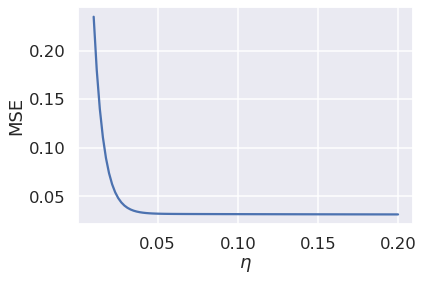

In [311]:
### batch gradient descent ###

etas = np.linspace(0.01, 0.2, 100) #list of hyperparameters
thetas = [] #initiate
MSEs = [] #initiate
m = len(X)
X_d = np.c_[np.ones((m, 1)), X, X**2] #design matrix

def  gradient_descent(theta_guess, eta, tol=1e-4):
    """Given a parameter guess, theta_guess, for the parameters, and a
        hyperparameter eta, returns an optimized parameter, theta, and
        the number of iterations of gradient descent before stepsize
        < tol."""
    theta = theta_guess #initiate
    count = 0 #initiate
    
    condition = True
    while(condition): #do-while loop
        gradient = 2/m * X_d.T.dot(X_d.dot(theta) - y)
        theta = theta - eta * gradient        
        condition = np.linalg.norm(eta * gradient) > tol and count < 100
        count = count+1
        
    theta[np.isnan(theta)] = 0.0
    return theta, count

for i,eta in enumerate(etas):
    theta0 = np.array([[0], [0], [0]]) #first guess is 0 polynomial
    thetas.append(gradient_descent(theta0, eta)[0])
    
    #calculate MSE
    y_pred = X_d.dot(thetas[i])
    MSEs.append(mean_squared_error(y,y_pred))

#plot learning curve
fig,ax = plt.subplots(1,1)
ax.plot(etas, MSEs)
ax.set_xlabel(r'$\eta$')
ax.set_ylabel("MSE")
thetas_BGD = thetas #save for later

#print best parameters
precision = 3 #choose number of digits to display
MSEs = np.array(MSEs)
min_index = np.where(MSEs == MSEs.min())[0][0] #find minimal MSE & corresponding parameters
print('model: y = a0 + a1 x + a2 x²')
print(f'best fit parameters: [a0 a1 a2] = {thetas[min_index].ravel()}')

model: y = a0 + a1 x + a2 x²
best fit parameters: [a0 a1 a2] = [2.08711989 0.75791532 0.60313749]


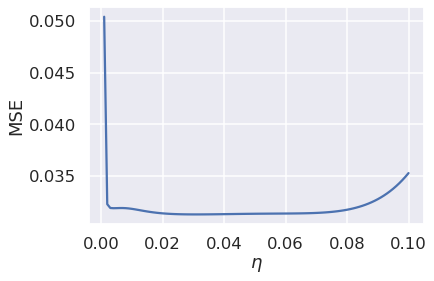

In [300]:
### stochastic gradient descent ###
etas = np.linspace(0.001, 0.1, 100) #list of hyperparameters
thetas = [] #initiate
MSEs = [] #initiate
m = len(X)
X_d = np.c_[X, X**2] #design matrix

for i,eta in enumerate(etas):
    sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=eta, learning_rate='constant', random_state=42)
    sgd_reg.fit(X_d, y.ravel())
    theta = np.append(sgd_reg.intercept_, sgd_reg.coef_)
    thetas.append(theta)
    
    #calculate MSE
    y_pred = sgd_reg.predict(X_d)
    MSEs.append(mean_squared_error(y,y_pred))

#plot learning curve
fig,ax = plt.subplots(1,1)
ax.plot(etas, MSEs)
ax.set_xlabel(r'$\eta$')
ax.set_ylabel("MSE")
thetas_SGD = thetas #save for later

#print best parameters
precision = 3 #choose number of digits to display
MSEs = np.array(MSEs)
min_index = np.where(MSEs == MSEs.min())[0][0] #find minimal MSE & corresponding parameters
print('model: y = a0 + a1 x + a2 x²')
print(f'best fit parameters: [a0 a1 a2] = {thetas[min_index].ravel()}')


#### (b) Mini-batch gradient descent
Implement mini-batch gradient descent and use this method to find the best fit parameters. Details:
- use a mini-batch size of 20%
- apply a similar learning schedule as in the SGD example (you might have to tune the learning hyperprameters)
- perform 50 epochs 
- hint: the `numpy.random.permutation` function might be useful for creating the mini-batches. 
- Compare with the solutions from BGD and SGD.

model: y = a0 + a1 x + a2 x²
best fit parameters: [a0 a1 a2] = [1.9312444  0.91193356 0.5760968 ]


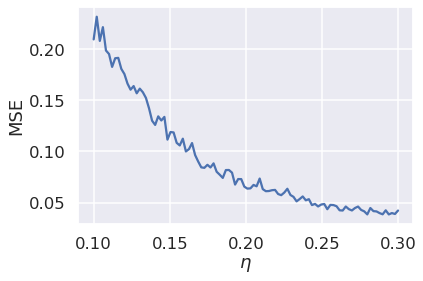

In [309]:
### mini-batch gradient descent ###

etas = np.linspace(0.1, 0.3, 100) #list of hyperparameters
thetas = [] #initiate
MSEs = [] #initiate
m = len(X)
nbr_batches = 5
X_d = np.c_[np.ones((m, 1)), X, X**2] #design matrix

def  gradient_descent(theta_guess, eta, tol=1e-4):
    """Given a parameter guess, theta_guess, for the parameters, and a
        hyperparameter eta, returns an optimized parameter, theta, and
        the number of iterations of gradient descent before stepsize
        < tol."""
    theta = theta_guess #initiate
    count = 0 #initiate
    
    condition = True
    while(condition): #do-while loop
        batch_indices = np.random.permutation(m)[0:int(m/nbr_batches)]
        
        gradient = 2/m * X_d[batch_indices].T.dot(X_d[batch_indices].dot(theta) - y[batch_indices])
        theta = theta - eta * gradient        
        condition = np.linalg.norm(eta * gradient) > tol and count < 100
        count = count+1
        
    theta[np.isnan(theta)] = 0.0
    return theta, count

for i,eta in enumerate(etas):
    theta0 = np.array([[0], [0], [0]]) #first guess is 0 polynomial
    thetas.append(gradient_descent(theta0, eta)[0])

    #calculate MSE
    y_pred = X_d.dot(thetas[i])
    MSEs.append(mean_squared_error(y,y_pred))

#plot learning curve
fig,ax = plt.subplots(1,1)
ax.plot(etas, MSEs)
ax.set_xlabel(r'$\eta$')
ax.set_ylabel("MSE")
thetas_mBGD = thetas #save for later

#print best parameters
precision = 3 #choose number of digits to display
MSEs = np.array(MSEs)
min_index = np.where(MSEs == MSEs.min())[0][0] #find minimal MSE & corresponding parameters
print('model: y = a0 + a1 x + a2 x²')
print(f'best fit parameters: [a0 a1 a2] = {thetas[min_index].ravel()}')

#### (c) Convergence
Compare the convergence pattern for the BGD, SGD and MGD, i.e. plot the path towards the optimal set of parameters. 
- Note that the path is in 3D (since there are three parameters in our quadratic model). You can plot 2D projections of the path.

Text(0, 0.5, '$\\theta_1$')

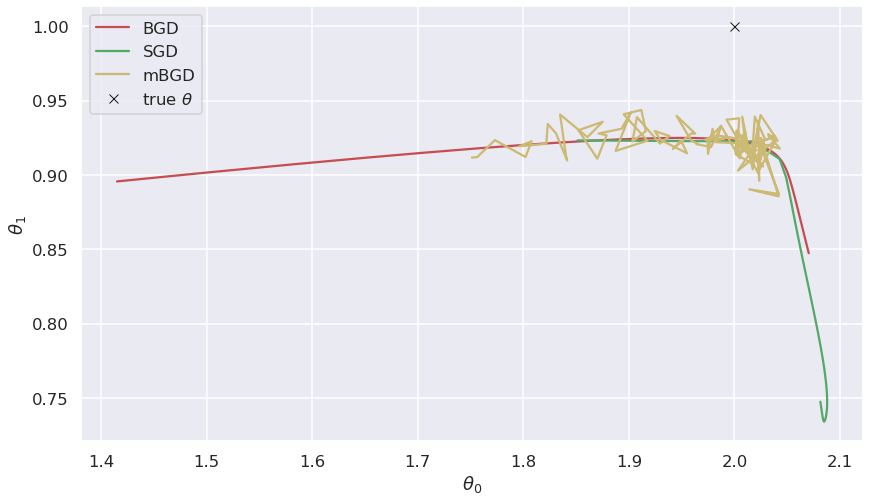

In [306]:
### format/project thetas ###
thetas_BGD_proj = np.array([th[0:2] for th in thetas_BGD])
thetas_SGD_proj = np.array([th[0:2] for th in thetas_SGD])
thetas_mBGD_proj = np.array([th[0:2] for th in thetas_mBGD])
true_theta = np.array([2., 1., 0.5])

#plot learning curve
fig,ax = plt.subplots(figsize=(14,8))
ax.plot(thetas_BGD_proj[:,0], thetas_BGD_proj[:,1], 'r', label='BGD')
ax.plot(thetas_SGD_proj[:,0], thetas_SGD_proj[:,1], 'g', label='SGD')
ax.plot(thetas_mBGD_proj[:,0], thetas_mBGD_proj[:,1], 'y', label='mBGD')
ax.plot(true_theta[0], true_theta[1], 'kx',label=r'true $\theta$')
ax.legend(loc='upper left')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')